In [1]:
import sys
sys.path.append('../../')

import jax
import jax.numpy as np
import numpy as onp
import os
import matplotlib.pyplot as plt
from discretization2D import *
from solver import *
from plot import *

os.environ["CUDA_VISIBLE_DEVICES"]="2"
jax.config.update("jax_enable_x64", True)
%matplotlib notebook

In [2]:
### 2D box mesh
domain_x = 1.
domain_y = 1.
Nx = 128
Ny = 128
cell_num = Nx*Ny
num_nodes = (Nx + 1) * (Ny + 1)
x = onp.linspace(0., domain_x, Nx + 1)
y = onp.linspace(0., domain_y, Ny + 1)
xx, yy = onp.meshgrid(x, y, indexing='ij')
points = onp.vstack([xx.reshape(-1), yy.reshape(-1)]).T

xc = np.array((xx[1:, 1:] + xx[:-1, 1:])/2)[:, :,None]
yc = np.array((yy[1:, 1:] + yy[1:, :-1])/2)[:, :,None]

dX = np.array([domain_x/Nx, domain_y/Ny])

### BC: -x,+x,-y,+y; 0 for dirichlet, 1 for neumann
BCs = [0,0,0,0]
v1 = np.array([0.,0.,])
v2 = np.array([1.,0.,])
values = [v1,v1,v1,v2]
BC_info = [BCs,values]

In [3]:
### example 1: transient solver, implicit 
def compute_residual_step1(vel,vel0,conv0,p0):
    vel_b = get_bound_values(vel,BC_info,dX)
    p_b = get_bound_values(p0,[[1,1,1,1],[0,0,0,0]],dX)
    res = ((vel-vel0)/dt*dX[0]*dX[1] + 
            conv0 - 
            diffusion(vel,vel_b,visco,dX) +
            gradient(p0,p_b,dX)*dX[0]*dX[1])
            
    return res.flatten()

def compute_residual_step2(p,vel_f):
    u_f,v_f = vel_f
    p_b = get_bound_values(p,[[1,1,1,1],[0,0,0,0]],dX)
    res = diffusion(p,p_b,1,dX) - ((u_f[1:,:]-u_f[:-1,:])*dX[1] + (v_f[:,1:]-v_f[:,:-1])*dX[0])/dt
#     res = res.at[0,0].set(p[0,0])
    return res.flatten()

@jax.jit
def time_integration(vel0,conv0,p0):
    def A_fn(f):
        vel = f.reshape((Nx,Ny,-1))
        return compute_residual_step1(vel,vel0,conv0,p0)

    dofs = np.zeros(Nx*Ny*2)
    dofs,res = solver_linear(A_fn,dofs)

    vel_star = dofs.reshape(Nx,Ny,-1)
    vel_star_f = get_face_values(vel_star,BC_info,dX)

    def A_fn(f):
        p = f.reshape((Nx,Ny,-1))
        return compute_residual_step2(p,vel_star_f)

    dofs = np.zeros(Nx*Ny*1)
    dofs,res = solver_linear_cg(A_fn,dofs)

    p = dofs.reshape(Nx,Ny,-1)
    p_b = get_bound_values(p,[[1,1,1,1],[0,0,0,0]],dX)
    vel = vel_star - dt*gradient(p,p_b,dX)

    vel_f = get_face_values(vel,BC_info,dX)
    vel_b = get_bound_values(vel,BC_info,dX)
    conv = convection(vel,vel_b,vel_f,dX)
    
    return vel,conv,p+p0

In [ ]:
%%time
Re = 1000
visco = 1./Re
dt = 0.005
vel0 = np.zeros((Nx,Ny,2))
p0 = np.zeros((Nx,Ny,1))
vel0_b = get_bound_values(vel0,BC_info,dX)
vel0_f = get_face_values(vel0,BC_info,dX)
conv0 = convection(vel0,vel0_b,vel0_f,dX)

max_step = 5000
for i in range(0,max_step):
    vel0,conv0,p0 = time_integration(vel0,conv0,p0)

In [ ]:
plot_lcd_contour(vel0,xc,yc,Re,interval=10)
plot_lcd_compare(vel0,xc,yc,Re,legend='calculated')

In [226]:
### example 1: transient solver, implicit 
def compute_residual_step1(vel,vel0,vel1,conv0,conv1,p0):
    
    vel_b = get_bound_values(vel,BC_info,dX)
    p_b = get_bound_values(p0,[[1,1,1,1],[0,0,0,0]],dX)
    conv = 2*conv0 - conv1
    
    res = ((3*vel-4*vel0+vel1)/2/dt*dX[0]*dX[1] + 
            conv - 
            diffusion(vel,vel_b,visco,dX) +
            gradient(p0,p_b,dX)*dX[0]*dX[1])
            
    return res.flatten()

def compute_residual_step2(p,vel_f):
    u_f,v_f = vel_f
    p_b = get_bound_values(p,[[1,1,1,1],[0,0,0,0]],dX)
    res = diffusion(p,p_b,1,dX) - ((u_f[1:,:]-u_f[:-1,:])*dX[1] + (v_f[:,1:]-v_f[:,:-1])*dX[0])*3/2/dt
#     res = res.at[0,0].set(p[0,0])
    return res.flatten()

@jax.jit
def time_integration(vel0,vel1,conv0,conv1,p0):
    def A_fn(f):
        vel = f.reshape((Nx,Ny,-1))
        return compute_residual_step1(vel,vel0,vel1,conv0,conv1,p0)

    dofs = np.zeros(Nx*Ny*2)
    dofs,res = solver_linear(A_fn,dofs)

    vel_star = dofs.reshape(Nx,Ny,-1)
    vel_star_f = get_face_values(vel_star,BC_info,dX)

    def A_fn(f):
        p = f.reshape((Nx,Ny,-1))
        return compute_residual_step2(p,vel_star_f)

    dofs = np.zeros(Nx*Ny*1)
    dofs,res = solver_linear_cg(A_fn,dofs)

    p = dofs.reshape(Nx,Ny,-1)
    p_b = get_bound_values(p,[[1,1,1,1],[0,0,0,0]],dX)
    vel = vel_star - 2*dt/3*gradient(p,p_b,dX)

    vel_f = get_face_values(vel,BC_info,dX)
    vel_b = get_bound_values(vel,BC_info,dX)
    conv = convection(vel,vel_b,vel_f,dX)
    
    return vel,vel0,conv,conv0,p+p0

In [227]:
%%time
Re = 100
visco = 1./Re
dt = 0.05
vel0 = np.zeros((Nx,Ny,2))
vel1 = np.zeros((Nx,Ny,2))
p0 = np.zeros((Nx,Ny,1))
vel0_b = get_bound_values(vel0,BC_info,dX)
vel0_f = get_face_values(vel0,BC_info,dX)
conv0 = convection(vel0,vel0_b,vel0_f,dX)
conv1 = conv0

max_step = 200
for i in range(0,max_step):
    vel0,vel1,conv0,conv1,p0 = time_integration(vel0,vel1,conv0,conv1,p0)

CPU times: user 11.6 s, sys: 43.5 ms, total: 11.6 s
Wall time: 10.8 s


<IPython.core.display.Javascript object>


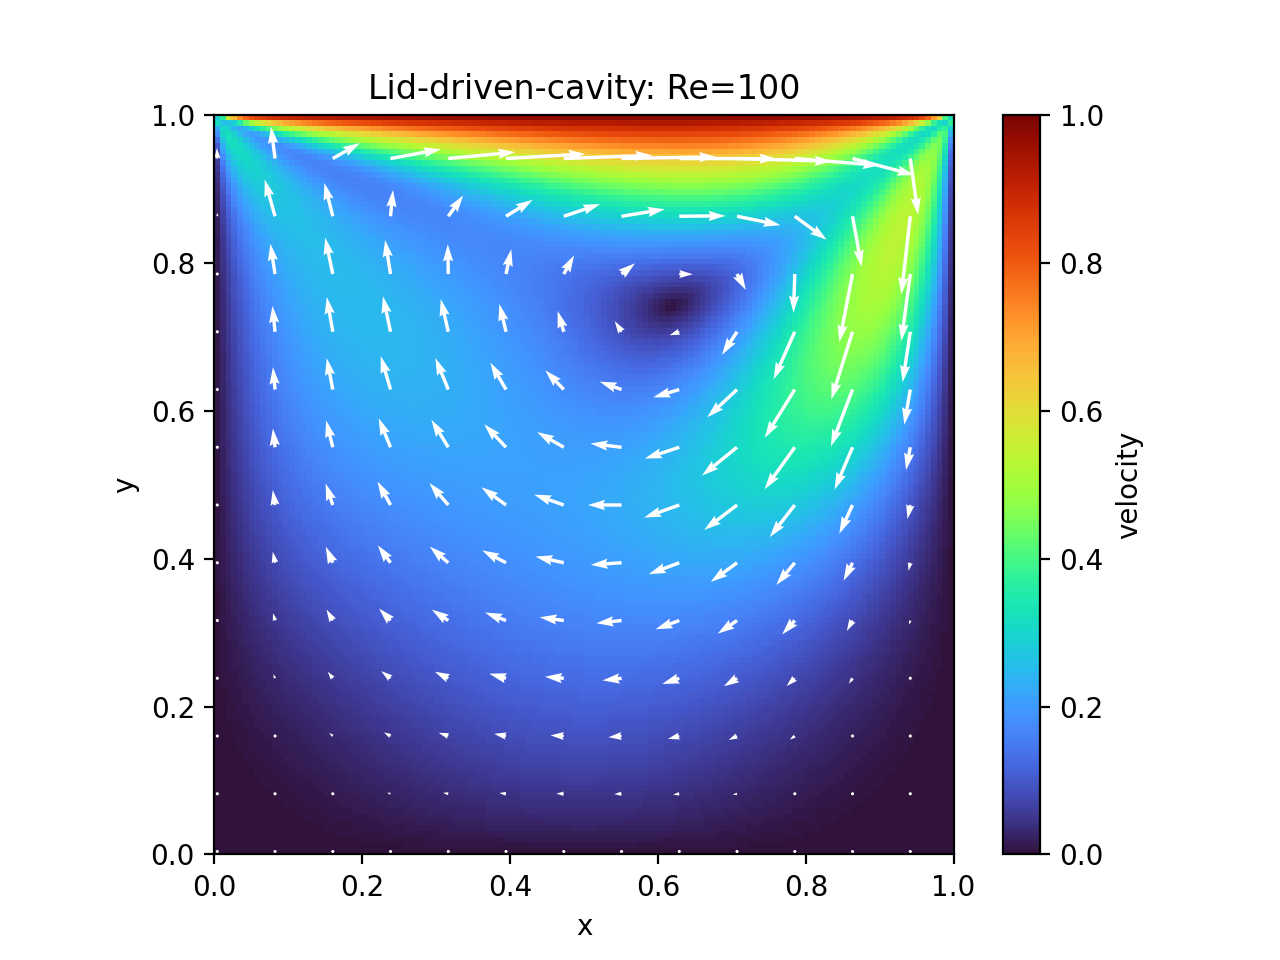

<IPython.core.display.Javascript object>


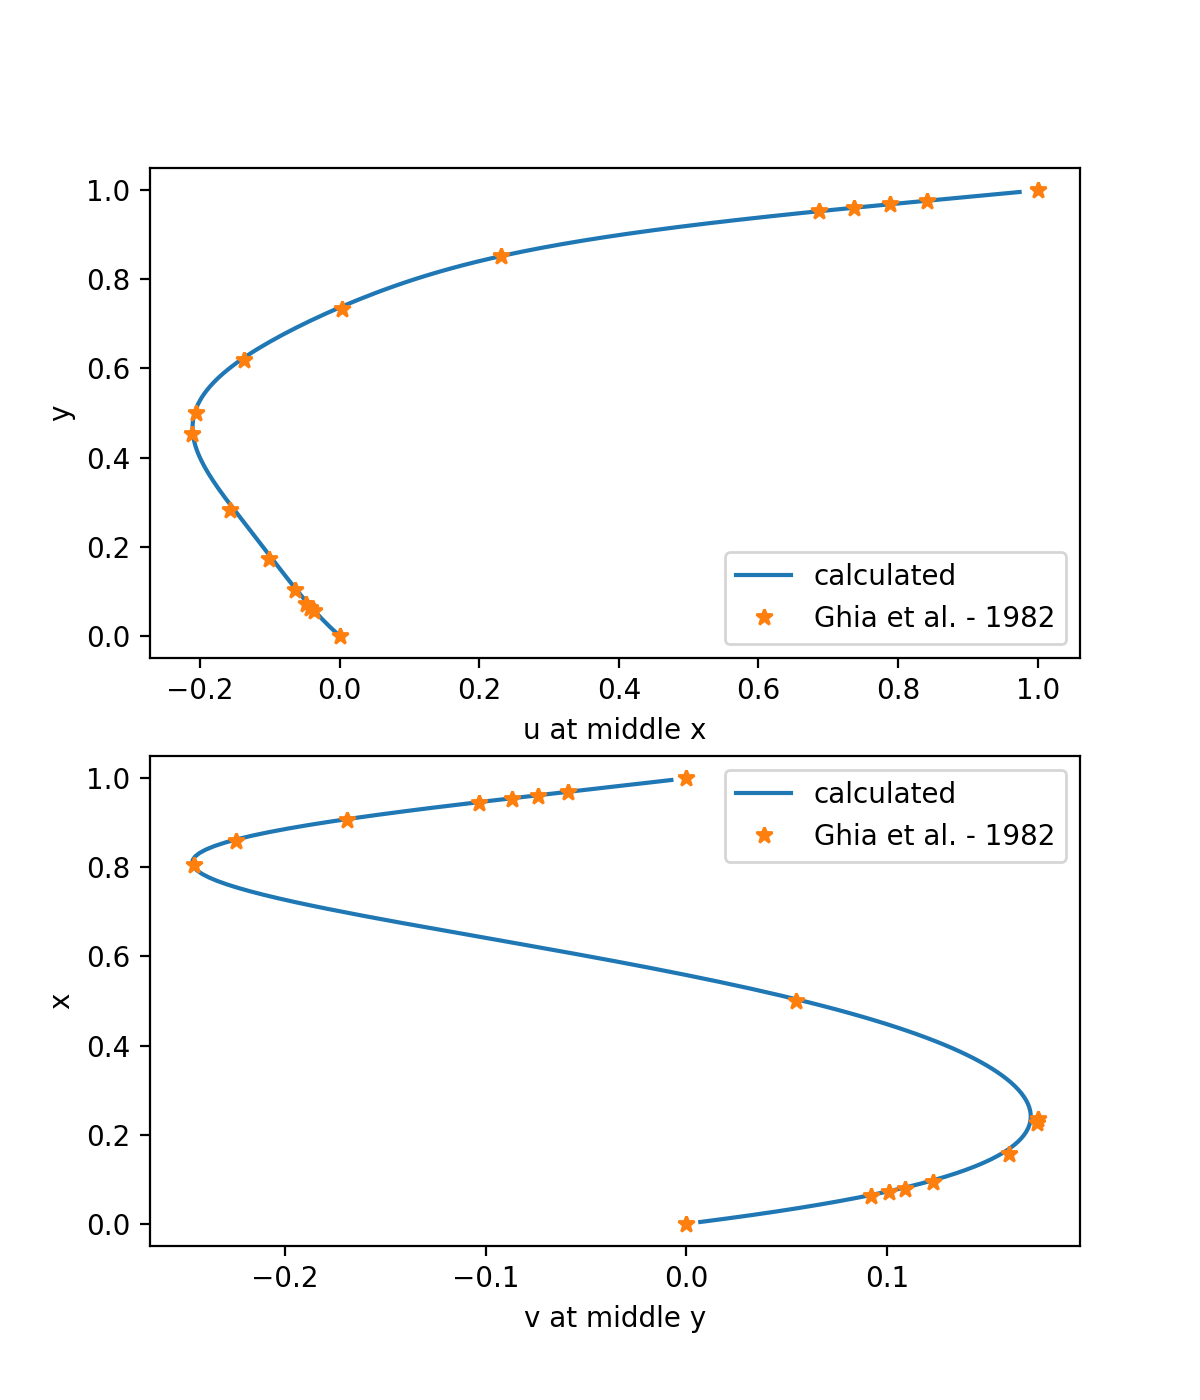

In [229]:
plot_lcd_contour(vel0,xc,yc,Re,interval=10)
plot_lcd_compare(vel0,xc,yc,Re,legend='calculated')

<IPython.core.display.Javascript object>


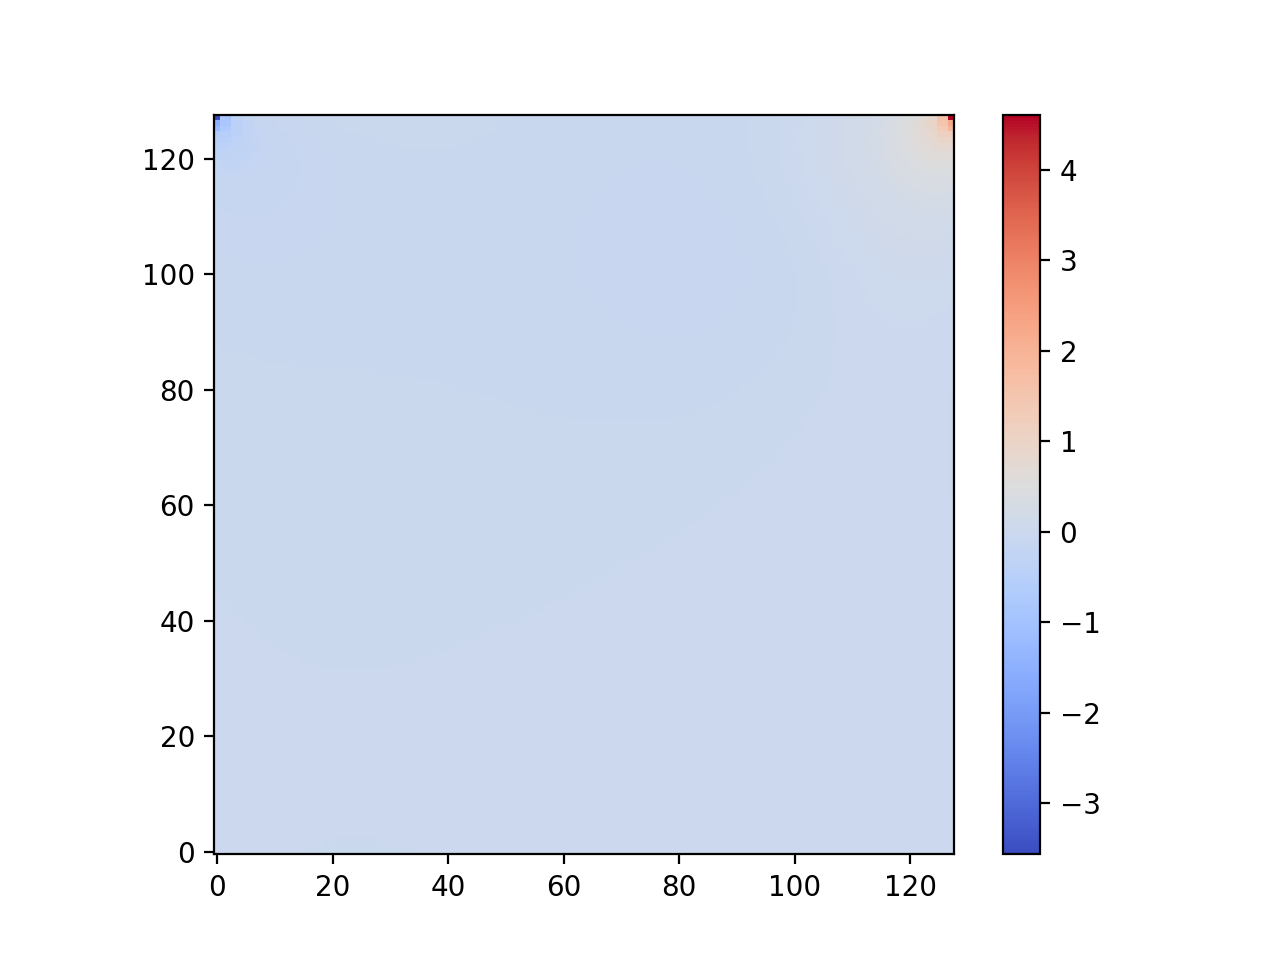

In [225]:
plt.figure()
plt.imshow(p0[:,:,-1].T,origin='lower',cmap='coolwarm')
plt.colorbar()